In [18]:
import torch
from Nets import NetTaskIL
from functions import test
from dataloaders.mnist import MNIST_for_classes_TaskIL, MNIST
from dataloaders.noise import dataloader_pretraining_gray
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import wandb

torch.cuda.is_available()
device = 'cuda'

In [20]:
import torch.nn.functional as F

def train_validation_all_classes(model, optimizer, tasks, rehersal_loader, epoch=1, log_interval = 1000):
    train_losses = []
    tasks_acc = [[], [], [], [], []]
    exemplers = []

    rehersal_iterator = iter(rehersal_loader)

    model.train()
    for taskNo in range(len(tasks)):
        for batch_idx, (data, target) in enumerate(tasks[taskNo]):
            rehersal_data = next(rehersal_iterator)

            optimizer.zero_grad()
            output = model(taskNo, data)
            loss = F.cross_entropy(output, target)
            # loss.backward()
            # optimizer.step()

            # optimizer.zero_grad()
            output = model(taskNo, rehersal_data[0])
            loss += F.cross_entropy(output, torch.tensor(np.random.randint(0, 2, size=len(rehersal_data[0])), dtype=torch.int64))
            loss.backward()
            optimizer.step()

            if batch_idx % log_interval == 0:
                print(f"Train [{batch_idx * len(data)} / {len(tasks[taskNo].dataset)}]       loss: {loss.item()}")
                for i in range(len(tasks)):
                    curr_task_acc = test(model, tasks[i], i, print_accuracy=False)
                    tasks_acc[i].append(curr_task_acc)
                    wandb.log({f"acc_task_{i}": curr_task_acc})

            train_losses.append(loss.item())
            wandb.log({"loss": loss.item()})
            exemplars = tasks[taskNo].batch_size * batch_idx
            exemplers.append(exemplars)
            wandb.log({"exemplers": exemplers*2})
    return train_losses, tasks_acc, exemplers

def test(model, test_loader, taskNo, print_accuracy=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(taskNo, data)
            test_loss += F.cross_entropy(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    if print_accuracy:
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

In [3]:
task1 = MNIST_for_classes_TaskIL(0, 1)
task2 = MNIST_for_classes_TaskIL(2, 3)
task3 = MNIST_for_classes_TaskIL(4, 5)
task4 = MNIST_for_classes_TaskIL(6, 7)
task5 = MNIST_for_classes_TaskIL(8, 9)

tasks = [task1 ,task2, task3, task4, task5]

_, _, test_loader = MNIST()

rehersal_loader = dataloader_pretraining_gray("dead_leaves-mixed", no_classes=2)

c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Loading data from data/dead_leaves-mixed/ as imagefolder


acc_task_0,▁▇███████████████████████▅▅▅▅▄▅▅▆▇▇▇▆▆▆▇
acc_task_1,▁▂▁▁▁▁▁▁▁██████████████████████████▇▇███
acc_task_2,▃▃▃▃▃▃▃▃▃▁▂▂▂▂▃▃▂▇███████▇▆▆▆▆▆▆▆▇▇▇▇▇▇▇
acc_task_3,▃▃▃▃▃▃▃▃▃▃▃▂▁▁▁▁▁▂▄▄▄▄▄▄▇███████████▇███
acc_task_4,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███▇███
loss,█▂▁▁▁▁▁▁▁▆▂▂▂▂▂▂▂▃▁▁▁▁▁▁▆▂▁▁▁▁▁▁▇▃▂▂▃▂▁▁
acc_task_0,99.04461
acc_task_1,95.63239
acc_task_2,91.36109
acc_task_3,98.46507
acc_task_4,98.77119


Train [0 / 12665]       loss: 1.4189485311508179
Train [1280 / 12665]       loss: 0.7708259224891663
Train [2560 / 12665]       loss: 0.7207081913948059
Train [3840 / 12665]       loss: 0.7170543670654297
Train [5120 / 12665]       loss: 0.7180823683738708
Train [6400 / 12665]       loss: 0.758379340171814
Train [7680 / 12665]       loss: 0.6861191987991333
Train [8960 / 12665]       loss: 0.7024725079536438
Train [10240 / 12665]       loss: 0.7078021168708801
Train [11520 / 12665]       loss: 0.704230010509491
Train [0 / 12089]       loss: 1.3788163661956787
Train [1280 / 12089]       loss: 1.1103049516677856
Train [2560 / 12089]       loss: 1.1306214332580566
Train [3840 / 12089]       loss: 0.7792814373970032
Train [5120 / 12089]       loss: 0.725306510925293
Train [6400 / 12089]       loss: 0.7664077281951904
Train [7680 / 12089]       loss: 0.750342607498169
Train [8960 / 12089]       loss: 0.7515674829483032
Train [10240 / 12089]       loss: 0.7491601705551147
Train [11520 / 1208

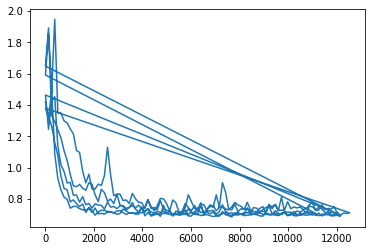

In [24]:
wandb.init(
    # set the wandb project where this run will be logged
    project="rehersal small net MNIST",
    
    # track hyperparameters and run metadata
    config={
    "setup": "task IL",
    "learning_rate": 0.1,
    "architecture": "CNN",
    "dataset": "MNIST",
    "epochs": 1,
    }
)

model = NetTaskIL(10)
optimizer = optim.SGD(model.parameters(), lr=0.1)


train_losses, tasks_losses, exemplers = train_validation_all_classes(model, optimizer, tasks, rehersal_loader, epoch=1, log_interval = 10)

plt.plot(exemplers, train_losses)

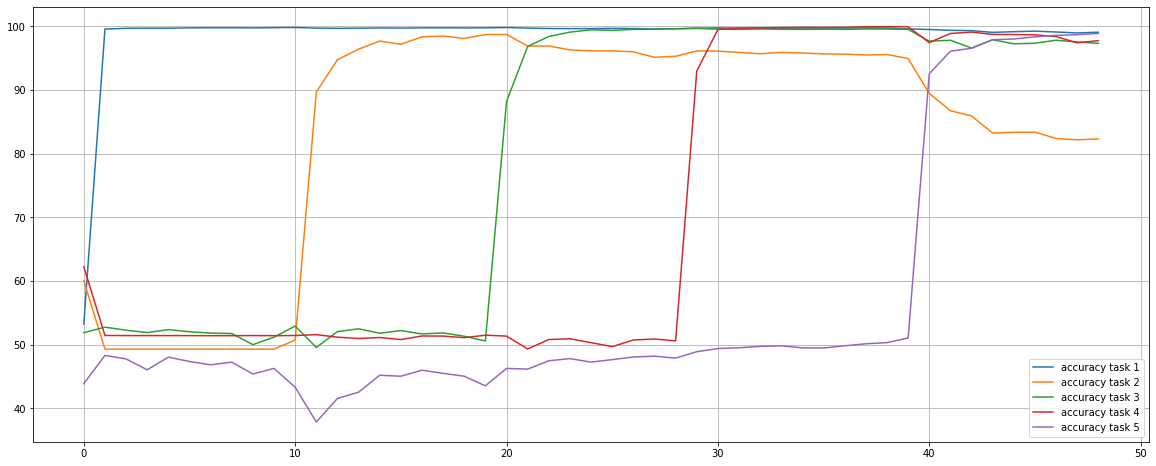

In [15]:
plt.figure(figsize=(20,8))
for i in range(len(tasks_losses)):
    plt.plot(tasks_losses[i])

plt.legend([f"accuracy task {i+1}" for i in range(len(tasks_losses))])
plt.grid()
plt.show()

In [ ]:
tasks_acc = tasks_losses

In [ ]:
# import pickle

# with open('taskILMNIST.pkl', 'wb') as f:
#     pickle.dump([tasks_acc, train_losses], f)